In [1]:
# automatically reload the package when it is modified
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import mediapy
from tqdm import tqdm
import dataclasses

from waymax import config as waymax_config
from waymax import dataloader
from waymax import datatypes
from waymax import visualization

2023-11-12 14:41:37.208446: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-12 14:41:37.208464: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-12 14:41:37.208820: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-12 14:41:37.693044: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# create a dataset
WOD_1_2_0_TRAIN_LOCAL = waymax_config.DatasetConfig(
    path='/Data/Dataset/Waymo/V1_2_tf/training/training_tfexample.tfrecord-00000-of-01000',
    max_num_rg_points=30000,
    data_format=waymax_config.DataFormat.TFRECORD,
)

config = dataclasses.replace(WOD_1_2_0_TRAIN_LOCAL, max_num_objects=32)
data_iter = dataloader.simulator_state_generator(config=config)


In [4]:
# get a scenario from the dataset
scenario : datatypes.SimulatorState = next(data_iter)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [5]:
# Meta Data
obj_metadata: datatypes.ObjectMetadata = scenario.object_metadata # Time independent metadata
log_trajectory: datatypes.Trajectory = scenario.sim_trajectory # Time dependent metadata

In [6]:
str_map = ['TYPE_UNSET', 'TYPE_VEHICLE', 'TYPE_PEDESTRIAN', 'TYPE_CYCLIST']
obj_types_int = obj_metadata.object_types
obj_types_str = [str_map[i] for i in obj_types_int]
print(obj_types_str)

['TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE', 'TYPE_VEHICLE']


In [7]:
# sdc_track_index = np.where(obj_metadata.is_sdc)[0][0]
obj_ids = obj_metadata.ids
sdc_track_index = obj_ids[obj_metadata.is_sdc][0] # only one sdc
track_index_to_predict = obj_ids[obj_metadata.is_modeled]
history_length = 11
timestamps = log_trajectory.timestamp_micros[0, :history_length]/1e6

# [cx, cy, cz, length, width, height, heading, vel_x, vel_y, valid]
obj_trajs = np.stack([
    log_trajectory.x,
    log_trajectory.y,
    log_trajectory.z,
    log_trajectory.length,
    log_trajectory.width,
    log_trajectory.height,
    log_trajectory.yaw,
    log_trajectory.vel_x,
    log_trajectory.vel_y,
    log_trajectory.valid,
], axis=-1) # [num_tracks, num_steps, 10]

""

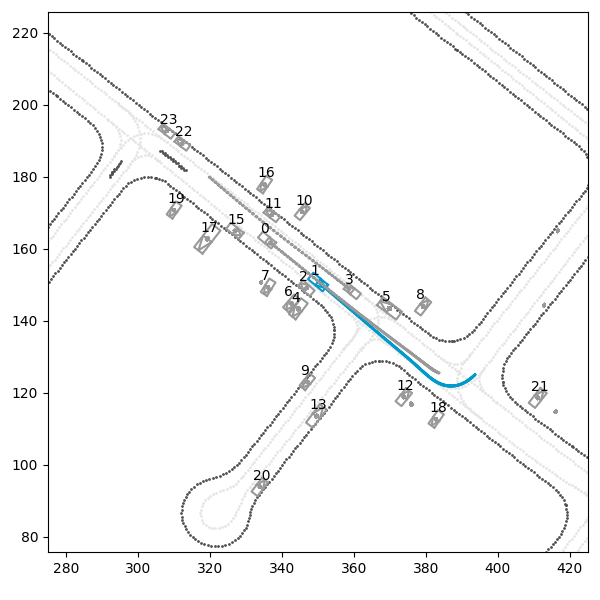

In [8]:
# Using logged trajectory
img = visualization.plot_simulator_state(scenario, use_log_traj=True)
mediapy.show_image(img)

In [9]:
map_data: datatypes.RoadgraphPoints = scenario.roadgraph_points


map_data_stack = np.stack([
    map_data.x,
    map_data.y,
    map_data.z,
    map_data.dir_x,
    map_data.dir_y,
    map_data.dir_z,
    map_data.types,
    map_data.ids,
    map_data.valid,
], axis=-1) # [num_tracks, num_steps, 9]

In [10]:
map_data_stack.shape

(30000, 9)

In [22]:
from rl_env.waymax_env import WaymaxEnv
from rl_env.env_utils import __collate_batch__
from tools.mtr_lightning import MTR_Lightning


In [19]:
waymax_env = WaymaxEnv()
model = MTR_Lightning.load_from_checkpoint('output/bc_atten_2_freeze/epoch=49-step=152600.ckpt')
_ = model.cuda()

In [28]:
scenario : datatypes.SimulatorState = next(data_iter)
data_batch_sim = __collate_batch__([waymax_env.extract_scene_data(scenario)])
action = model.sample(data_batch_sim, -1)[-1]

In [29]:
print(action)

[[ 3.8984874e-01  1.5072817e-03  4.2403486e-04]
 [ 3.4852076e-01 -2.2045081e-04  3.2243368e-03]
 [ 1.0350984e+00  1.1221097e-02 -4.8473710e-04]]
